In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

from lmfit import Parameters, minimize, fit_report
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

In [2]:
def power_fit_lmfit(params, x, y):
        a = params['a']
        b = params['b']
        y_fit = a* x **b
        
        return y_fit-y

In [3]:
dataBase_path = r'./'
dataBase_file = r'UUVDatabase.xlsx'
biological_file = r'biological_COT_Data.ods'

In [4]:
data_path = Path(dataBase_path, dataBase_file)
bcfDF = pd.read_excel(data_path, sheet_name = 'BCF')
mpfDF = pd.read_excel(data_path, sheet_name='MPF')
convDF = pd.read_excel(data_path, sheet_name = 'Propeller')
liftDF = pd.read_excel(data_path, sheet_name="LiftBased")

data_path = Path(dataBase_path, biological_file)
bioDF = pd.read_excel(data_path, sheet_name='Videler and Nolet')
bio_kinematics = pd.read_excel(data_path, sheet_name='Videler Kinematic')
bioDF = bioDF.sort_values('Weight [kg]')

In [5]:
conv_cot = convDF[convDF['COTopt [J/m]'].notnull()]
bcf_cot = bcfDF[bcfDF['COTopt [J/m]'].notnull()]
mpf_cot = mpfDF[mpfDF['COTopt [J/m]'].notnull()]
lift_cot = liftDF[liftDF['COTopt [J/m]'].notnull()]

# sort the column values in ascending order
conv_cot = conv_cot.sort_values('Weight [kg]')
bcf_cot = bcf_cot.sort_values('Weight [kg]')
mpf_cot = mpf_cot.sort_values('Weight [kg]')
lift_cot = lift_cot.sort_values('Weight [kg]')

# drop all rows with nan values
conv_cot.dropna(subset=['Weight [kg]'], inplace=True)
bcf_cot.dropna(subset=['Weight [kg]'], inplace=True)
mpf_cot.dropna(subset=['Weight [kg]'], inplace=True)
lift_cot.dropna(subset=['Weight [kg]'], inplace=True)

In [6]:
# break up the data frame into perspective locomotion modes
bio_modes = bioDF['Mode'].unique()
conv_modes = conv_cot['Locomotion'].unique()
bcf_modes = bcf_cot['Locomotion'].unique()
mpf_modes = mpf_cot['Locomotion'].unique()
lift_modes = lift_cot['Locomotion'].unique()

bio_dfs = [bioDF[bioDF['Mode']==mode] for mode in bio_modes]
conv_dfs = [conv_cot[conv_cot['Locomotion']==mode] for mode in conv_modes]
bcf_dfs = [bcf_cot[bcf_cot['Locomotion']==mode] for mode in bcf_modes]
mpf_dfs = [mpf_cot[mpf_cot['Locomotion']==mode] for mode in mpf_modes]
lift_dfs = [lift_cot[lift_cot['Locomotion']==mode] for mode in lift_modes]

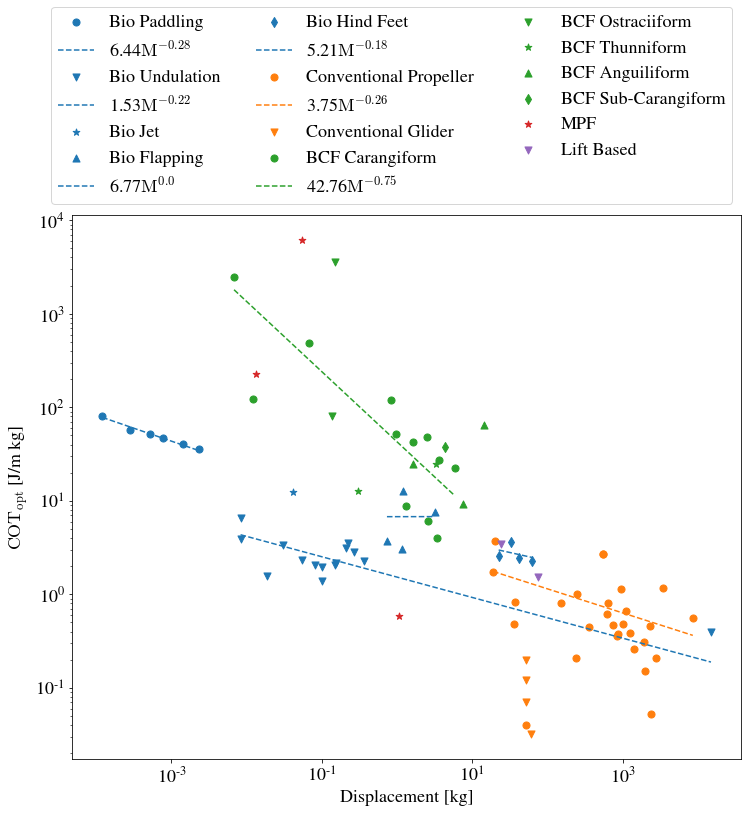

In [7]:
# Plot COT and displacement
plt.rcParams.update({'font.size':18})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'STIXGeneral'})

fig1, ax1 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']


for i, mode in enumerate(bio_modes):
        col = 'C0'
        # perform fits for data
        # Defining the various parameters
        params = Parameters()
        # Slope is bounded between min value of 1.0 and max value of 3.0
        params.add('a', min=0.001, max=10.0)
        # Intercept is made fixed at 0.0 value
        params.add('b', min=-0.75, max=0.001)
        if mode == 'Jet':
                ax1.scatter(bio_dfs[i]['Weight [kg]'], bio_dfs[i]['COTopt [J/kgm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
        else:
                bio_fit = minimize(power_fit_lmfit, params, args=(bio_dfs[i]['Weight [kg]'], bio_dfs[i]['COTopt [J/kgm]'],), method=fit_method)
                
                ax1.scatter(bio_dfs[i]['Weight [kg]'], bio_dfs[i]['COTopt [J/kgm]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax1.plot(bio_dfs[i]['Weight [kg]'], bio_fit.params['a'].value*bio_dfs[i]['Weight [kg]'].values**bio_fit.params['b'].value, col + '--', 
                label=str(np.round(bio_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(bio_fit.params['b'].value,2)) + '}}$')                

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        # Defining the various parameters
        params = Parameters()
        # Slope is bounded between min value of 1.0 and max value of 3.0
        params.add('a', min=0.001, max=10.0)
        # Intercept is made fixed at 0.0 value
        params.add('b', min=-0.75, max=0.001)
        if mode == 'Propeller':
                conv_fit = minimize(power_fit_lmfit, params, args=(conv_dfs[i]['Weight [kg]'], conv_dfs[i]['COTopt [J/kgm]'],), method=fit_method)
                
                ax1.scatter(conv_dfs[i]['Weight [kg]'], conv_dfs[i]['COTopt [J/kgm]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                ax1.plot(conv_dfs[i]['Weight [kg]'], conv_fit.params['a'].value*conv_dfs[i]['Weight [kg]'].values**conv_fit.params['b'].value, col + '--', 
                label=str(np.round(conv_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(conv_fit.params['b'].value,2)) + '}}$')
        else:
                ax1.scatter(conv_dfs[i]['Weight [kg]'], conv_dfs[i]['COTopt [J/kgm]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

for i, mode in enumerate(bcf_modes):
        col = 'C2'
        # perform fits for data
        # Defining the various parameters
        params = Parameters()
        # Slope is bounded between min value of 1.0 and max value of 3.0
        params.add('a', min=0.001, max=100.0)
        # Intercept is made fixed at 0.0 value
        params.add('b', min=-0.75, max=0.001)
        if mode == 'Carangiform':
                bcf_fit = minimize(power_fit_lmfit, params, args=(bcf_dfs[i]['Weight [kg]'], bcf_dfs[i]['COTopt [J/kgm]'],), method=fit_method)

                ax1.scatter(bcf_dfs[i]['Weight [kg]'], bcf_dfs[i]['COTopt [J/kgm]'], marker=markers[i], color='C2', s=marker_size, label='BCF ' + mode)
                ax1.plot(bcf_dfs[i]['Weight [kg]'], bcf_fit.params['a'].value*bcf_dfs[i]['Weight [kg]'].values**bcf_fit.params['b'].value, 'C2--', 
                        label=str(np.round(bcf_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(bcf_fit.params['b'].value,2)) + '}}$')
        else:
                ax1.scatter(bcf_dfs[i]['Weight [kg]'], bcf_dfs[i]['COTopt [J/kgm]'], marker=markers[i], color='C2', s=marker_size, label='BCF ' + mode)

ax1.scatter(mpf_cot['Weight [kg]'], np.divide(mpf_cot['COTopt [J/m]'], mpf_cot['Weight [kg]']), marker='*', color='C3', s=marker_size, label='MPF')
ax1.scatter(lift_cot['Weight [kg]'], np.divide(lift_cot['COTopt [J/m]'], lift_cot['Weight [kg]']), marker='v', color='C4', s=marker_size, label='Lift Based')

ax1.set_xticks(np.arange(1e-5, 1e5, 10))
ax1.set_xlabel('Displacement [kg]')
ax1.set_ylabel('$\mathrm{COT_{opt}}$ [J/m kg]')
ax1.legend(ncol=3, bbox_to_anchor=(1.0, 1.4))

# ax2 = plt.axes([0,0,1,1])
# ip = InsetPosition(ax1, [0.45,0.2,0.5,0.5])
# ax2.set_axes_locator(ip)
# mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

# ax2.scatter(bcf_cot['Weight [kg]'], bcf_cot['COTopt [J/m]'], color='C1', label='BCF')
# ax2.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J/m]'], color='C2', label='MPF')
ax1.set_yscale('log')
ax1.set_xscale('log')
# ax2.set_yscale('log')
# ax2.set_xscale('log')

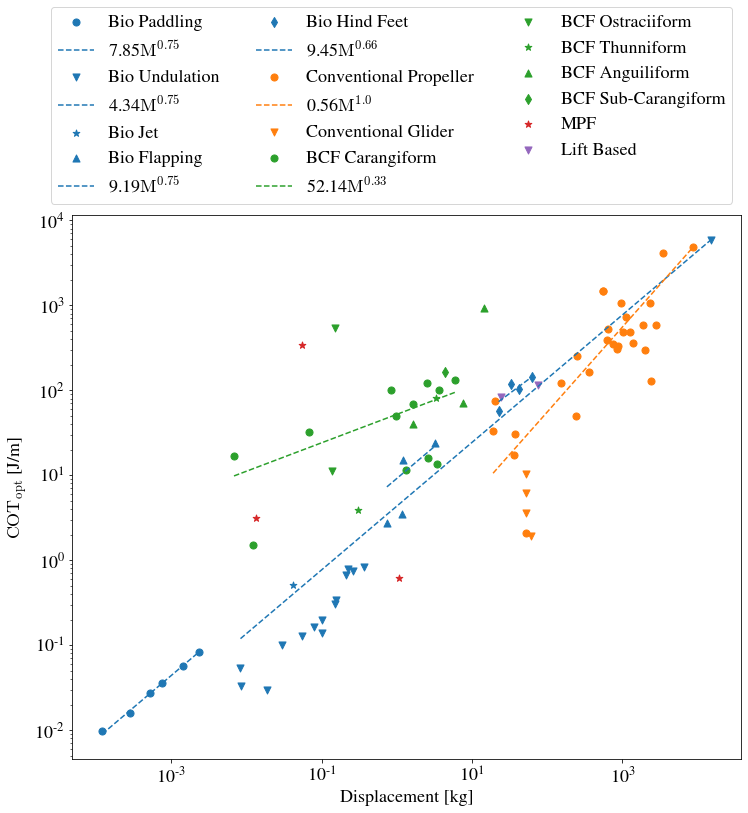

In [8]:
fig2, ax2 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']


for i, mode in enumerate(bio_modes):
        col = 'C0'
        # perform fits for data
        # Defining the various parameters
        params = Parameters()
        # Slope is bounded between min value of 1.0 and max value of 3.0
        params.add('a', min=0.001, max=10.0)
        # Intercept is made fixed at 0.0 value
        params.add('b', min=0.001, max=0.75)
        if mode == 'Jet':
                ax2.scatter(bio_dfs[i]['Weight [kg]'], bio_dfs[i]['COTopt [J/m]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
        else:
                bio_fit = minimize(power_fit_lmfit, params, args=(bio_dfs[i]['Weight [kg]'], bio_dfs[i]['COTopt [J/m]'],), method=fit_method)
                
                ax2.scatter(bio_dfs[i]['Weight [kg]'], bio_dfs[i]['COTopt [J/m]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax2.plot(bio_dfs[i]['Weight [kg]'], bio_fit.params['a'].value*bio_dfs[i]['Weight [kg]'].values**bio_fit.params['b'].value, col + '--', 
                label=str(np.round(bio_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(bio_fit.params['b'].value,2)) + '}}$')                

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        # Defining the various parameters
        params = Parameters()
        # Slope is bounded between min value of 1.0 and max value of 3.0
        params.add('a', min=0.001, max=10.0)
        # Intercept is made fixed at 0.0 value
        params.add('b', min=0.001, max=1.0)
        if mode == 'Propeller':
                conv_fit = minimize(power_fit_lmfit, params, args=(conv_dfs[i]['Weight [kg]'], conv_dfs[i]['COTopt [J/m]'],), method=fit_method)
                
                ax2.scatter(conv_dfs[i]['Weight [kg]'], conv_dfs[i]['COTopt [J/m]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                ax2.plot(conv_dfs[i]['Weight [kg]'], conv_fit.params['a'].value*conv_dfs[i]['Weight [kg]'].values**conv_fit.params['b'].value, col + '--', 
                label=str(np.round(conv_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(conv_fit.params['b'].value,2)) + '}}$')
        else:
                ax2.scatter(conv_dfs[i]['Weight [kg]'], conv_dfs[i]['COTopt [J/m]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

for i, mode in enumerate(bcf_modes):
        col = 'C2'
        # perform fits for data
        # Defining the various parameters
        params = Parameters()
        # Slope is bounded between min value of 1.0 and max value of 3.0
        params.add('a', min=0.001, max=100.0)
        # Intercept is made fixed at 0.0 value
        params.add('b', min=0.001, max=0.75)
        if mode == 'Carangiform':
                bcf_fit = minimize(power_fit_lmfit, params, args=(bcf_dfs[i]['Weight [kg]'], bcf_dfs[i]['COTopt [J/m]'],), method=fit_method)

                ax2.scatter(bcf_dfs[i]['Weight [kg]'], bcf_dfs[i]['COTopt [J/m]'], marker=markers[i], color='C2', s=marker_size, label='BCF ' + mode)
                ax2.plot(bcf_dfs[i]['Weight [kg]'], bcf_fit.params['a'].value*bcf_dfs[i]['Weight [kg]'].values**bcf_fit.params['b'].value, 'C2--', 
                        label=str(np.round(bcf_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(bcf_fit.params['b'].value,2)) + '}}$')
        else:
                ax2.scatter(bcf_dfs[i]['Weight [kg]'], bcf_dfs[i]['COTopt [J/m]'], marker=markers[i], color='C2', s=marker_size, label='BCF ' + mode)

ax2.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J/m]'], marker='*', color='C3', s=marker_size, label='MPF')
ax2.scatter(lift_cot['Weight [kg]'], lift_cot['COTopt [J/m]'], marker='v', color='C4', s=marker_size, label='Lift Based')

ax2.set_xticks(np.arange(1e-5, 1e5, 10))
ax2.set_xlabel('Displacement [kg]')
ax2.set_ylabel('$\mathrm{COT_{opt}}$ [J/m]')
ax2.legend(ncol=3, bbox_to_anchor=(1.0, 1.4))

# ax2 = plt.axes([0,0,1,1])
# ip = InsetPosition(ax1, [0.45,0.2,0.5,0.5])
# ax2.set_axes_locator(ip)
# mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

# ax2.scatter(bcf_cot['Weight [kg]'], bcf_cot['COTopt [J/m]'], color='C1', label='BCF')
# ax2.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J/m]'], color='C2', label='MPF')
ax2.set_yscale('log')
ax2.set_xscale('log')
# ax2.set_yscale('log')
# ax2.set_xscale('log')

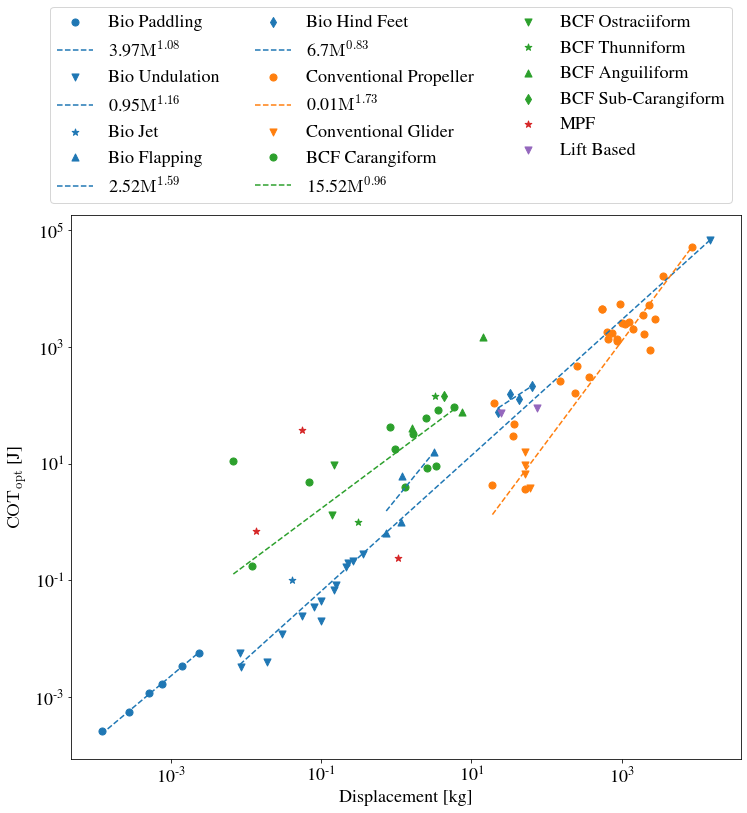

In [9]:
fig3, ax3 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']


for i, mode in enumerate(bio_modes):
        col = 'C0'
        # perform fits for data
        # Defining the various parameters
        params = Parameters()
        # Slope is bounded between min value of 1.0 and max value of 3.0
        params.add('a', min=0.001, max=10.0)
        # Intercept is made fixed at 0.0 value
        params.add('b', min=0.001, max=2.0)
        if mode == 'Jet':
                ax3.scatter(bio_dfs[i]['Weight [kg]'], bio_dfs[i]['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
        else:
                bio_fit = minimize(power_fit_lmfit, params, args=(bio_dfs[i]['Weight [kg]'], bio_dfs[i]['COTopt [J]'],), method=fit_method)
                
                ax3.scatter(bio_dfs[i]['Weight [kg]'], bio_dfs[i]['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Bio ' + mode)
                
                ax3.plot(bio_dfs[i]['Weight [kg]'], bio_fit.params['a'].value*bio_dfs[i]['Weight [kg]'].values**bio_fit.params['b'].value, col + '--', 
                label=str(np.round(bio_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(bio_fit.params['b'].value,2)) + '}}$')                

for i, mode in enumerate(conv_modes):
        col = 'C1'
        # perform fits for data
        # Defining the various parameters
        params = Parameters()
        # Slope is bounded between min value of 1.0 and max value of 3.0
        params.add('a', min=0.001, max=10.0)
        # Intercept is made fixed at 0.0 value
        params.add('b', min=0.001, max=2.0)
        if mode == 'Propeller':
                conv_fit = minimize(power_fit_lmfit, params, args=(conv_dfs[i]['Weight [kg]'], conv_dfs[i]['COTopt [J]'],), method=fit_method)
                
                ax3.scatter(conv_dfs[i]['Weight [kg]'], conv_dfs[i]['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)
                ax3.plot(conv_dfs[i]['Weight [kg]'], conv_fit.params['a'].value*conv_dfs[i]['Weight [kg]'].values**conv_fit.params['b'].value, col + '--', 
                label=str(np.round(conv_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(conv_fit.params['b'].value,2)) + '}}$')
        else:
                ax3.scatter(conv_dfs[i]['Weight [kg]'], conv_dfs[i]['COTopt [J]'], marker=markers[i], color=col, s=marker_size, label='Conventional ' + mode)

for i, mode in enumerate(bcf_modes):
        col = 'C2'
        # perform fits for data
        # Defining the various parameters
        params = Parameters()
        # Slope is bounded between min value of 1.0 and max value of 3.0
        params.add('a', min=0.001, max=100.0)
        # Intercept is made fixed at 0.0 value
        params.add('b', min=0.001, max=2.0)
        if mode == 'Carangiform':
                bcf_fit = minimize(power_fit_lmfit, params, args=(bcf_dfs[i]['Weight [kg]'], bcf_dfs[i]['COTopt [J]'],), method=fit_method)

                ax3.scatter(bcf_dfs[i]['Weight [kg]'], bcf_dfs[i]['COTopt [J]'], marker=markers[i], color='C2', s=marker_size, label='BCF ' + mode)
                ax3.plot(bcf_dfs[i]['Weight [kg]'], bcf_fit.params['a'].value*bcf_dfs[i]['Weight [kg]'].values**bcf_fit.params['b'].value, 'C2--', 
                        label=str(np.round(bcf_fit.params['a'].value, 2)) + '$\mathrm{M^{' + str(np.round(bcf_fit.params['b'].value,2)) + '}}$')
        else:
                ax3.scatter(bcf_dfs[i]['Weight [kg]'], bcf_dfs[i]['COTopt [J]'], marker=markers[i], color='C2', s=marker_size, label='BCF ' + mode)

ax3.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J]'], marker='*', color='C3', s=marker_size, label='MPF')
ax3.scatter(lift_cot['Weight [kg]'], lift_cot['COTopt [J]'], marker='v', color='C4', s=marker_size, label='Lift Based')

ax3.set_xticks(np.arange(1e-5, 1e5, 10))
ax3.set_xlabel('Displacement [kg]')
ax3.set_ylabel('$\mathrm{COT_{opt}}$ [J]')
ax3.legend(ncol=3, bbox_to_anchor=(1.0, 1.4))

# ax2 = plt.axes([0,0,1,1])
# ip = InsetPosition(ax1, [0.45,0.2,0.5,0.5])
# ax2.set_axes_locator(ip)
# mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

# ax2.scatter(bcf_cot['Weight [kg]'], bcf_cot['COTopt [J/m]'], color='C1', label='BCF')
# ax2.scatter(mpf_cot['Weight [kg]'], mpf_cot['COTopt [J/m]'], color='C2', label='MPF')
ax3.set_yscale('log')
ax3.set_xscale('log')
# ax2.set_yscale('log')
# ax2.set_xscale('log')

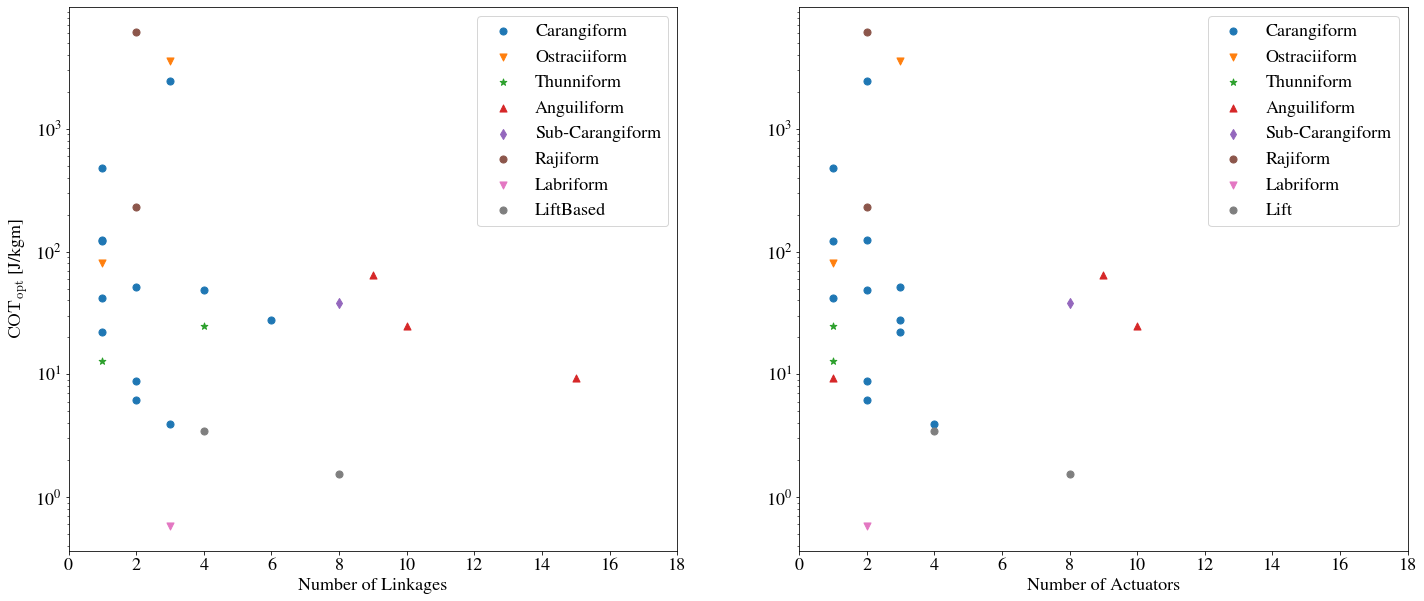